In [ ]:
!pip install mne numpy matplotlib

In [2]:
# --- Função RLS ---
class RLSFilter:
    def __init__(self, order, lambda_, delta):
        self.order = order
        self.lambda_ = lambda_
        self.delta = delta
        self.w = np.zeros(order)
        self.P = (1.0 / delta) * np.eye(order)

    def predict(self, x):
        return np.dot(self.w, x)

    def update(self, x, d):
        x = x.reshape(-1, 1)
        pi = self.P @ x
        k = pi / (self.lambda_ + x.T @ pi)
        e = d - self.w @ x.ravel()
        self.w += (k.ravel() * e)
        self.P = (self.P - k @ x.T @ self.P) / self.lambda_
        return e

**Os canais variam por paciente, mas em geral, os mais utilizados para detectar crises epilépticas são os frontais e temporais, como:**

- 'FP1-F7'

- 'F7-T7'

- 'T7-P7'

- 'FP2-F8'

- 'F8-T8'

- 'T8-P8'

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.ndimage import label

# --- Parâmetros ---
channels = ['FP1-F7', 'T7-P7', 'F7-T7']  # Lista dos canais que você quer analisar
order = 0 # order = 5
lambda_ = 0.99 # lambda_ = 1.50
delta = 0.1
k = 6  # Multiplicador do limiar (k=9 original)
duracao_minima = 10  # segundos (5 original)
tolerancia_entre_eventos = 2.0  # segundos
tolerancia_entre_crises = 25.0  # segundos

# Crises reais anotadas manualmente (exemplo)
crises_reais = [(1720, 1810)]  # em segundos

# --- Carregar arquivo
raw = mne.io.read_raw_edf("/content/drive/MyDrive/BOLSA PIBIC - KAUÃ E TIAGO/DATABASES/chb01_18.edf", preload=True)
sfreq = raw.info['sfreq']

# --- Para armazenar eventos detectados por canal
resultados_canais = {}

for channel in channels:
    print(f"Analisando canal: {channel}")

    # Extrair sinal
    data, times = raw.get_data(picks=[channel], return_times=True)
    signal = data[0]
    signal = (signal - np.mean(signal)) / np.std(signal)

    # Aplicar RLS
    rls = RLSFilter(order, lambda_, delta)
    errors = []

    for i in range(order, len(signal)):
        x = signal[i-order:i][::-1]
        d = signal[i]
        e = rls.update(x, d)
        errors.append(e)

    errors = np.array(errors)
    error_energy = errors ** 2

    # Definir limiar
    mean_err = np.mean(error_energy)
    std_err = np.std(error_energy)
    limiar = mean_err + k * std_err

    # Detecção inicial
    deteccao = error_energy > limiar
    labels, num_events = label(deteccao)

    eventos_raw = []
    for i in range(1, num_events + 1):
        indices = np.where(labels == i)[0]
        if len(indices) == 0:
            continue
        t_inicio = times[order:][indices[0]]
        t_fim = times[order:][indices[-1]]
        eventos_raw.append((t_inicio, t_fim))

    # Agrupar eventos próximos
    eventos_agrupados = []
    if eventos_raw:
        atual_inicio, atual_fim = eventos_raw[0]
        for inicio, fim in eventos_raw[1:]:
            if inicio - atual_fim <= tolerancia_entre_eventos:
                atual_fim = fim
            else:
                eventos_agrupados.append((atual_inicio, atual_fim))
                atual_inicio, atual_fim = inicio, fim
        eventos_agrupados.append((atual_inicio, atual_fim))

    # Filtrar por duração mínima
    eventos_finais = []
    for inicio, fim in eventos_agrupados:
        duracao = fim - inicio
        if duracao >= duracao_minima:
            eventos_finais.append((inicio, fim))

    resultados_canais[channel] = eventos_finais

# --- JUNTA eventos de todos canais ---
todos_eventos = []
for canal, eventos in resultados_canais.items():
    for inicio, fim in eventos:
        todos_eventos.append((inicio, fim, canal))

todos_eventos.sort()  # Organizar por início

# --- Fusão de crises
crises_confiaveis = []
crises_sem_credibilidade = []

if todos_eventos:
    inicio_atual, fim_atual, canais_ativos = todos_eventos[0][0], todos_eventos[0][1], {todos_eventos[0][2]}

    for evento in todos_eventos[1:]:
        inicio, fim, canal = evento
        if inicio <= fim_atual:
            fim_atual = max(fim_atual, fim)
            canais_ativos.add(canal)
        else:
            if len(canais_ativos) > 1:
                crises_confiaveis.append((inicio_atual, fim_atual, canais_ativos.copy()))
            else:
                crises_sem_credibilidade.append((inicio_atual, fim_atual, list(canais_ativos)[0]))
            inicio_atual, fim_atual, canais_ativos = inicio, fim, {canal}

    # Adicionar última crise
    if len(canais_ativos) > 1:
        crises_confiaveis.append((inicio_atual, fim_atual, canais_ativos.copy()))
    else:
        crises_sem_credibilidade.append((inicio_atual, fim_atual, list(canais_ativos)[0]))

Extracting EDF parameters from /content/drive/MyDrive/BOLSA PIBIC - KAUÃ E TIAGO/DATABASES/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipython-input-9-3802395044.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("/content/drive/MyDrive/BOLSA PIBIC - KAUÃ E TIAGO/DATABASES/chb01_18.edf", preload=True)


Analisando canal: FP1-F7
Analisando canal: T7-P7
Analisando canal: F7-T7



🧠 Crises confiáveis detectadas:
- De 1731.98s até 1809.01s | Canais: FP1-F7, F7-T7, T7-P7

⚠️ Crises sem credibilidade detectadas:


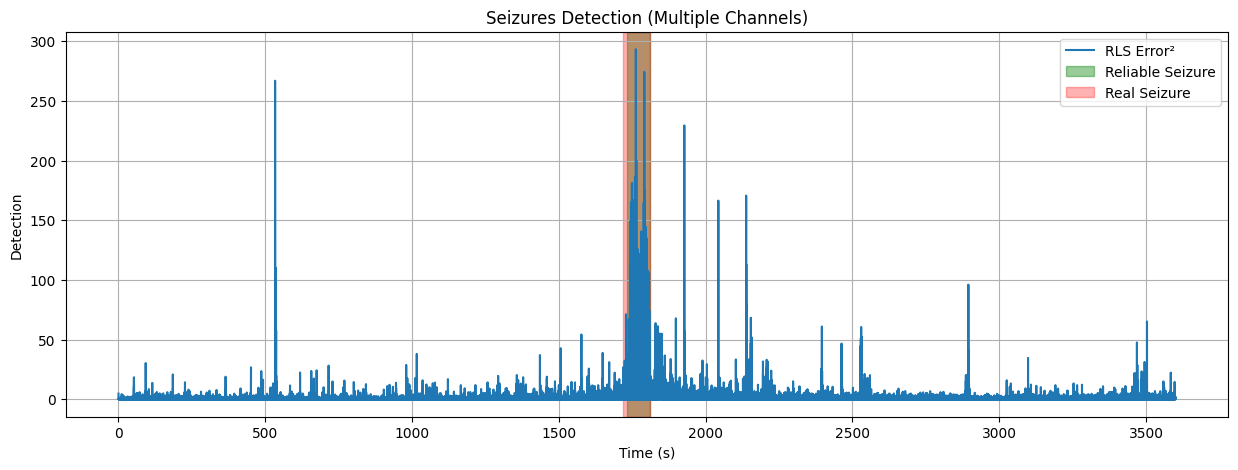

In [10]:
# --- Resultados Finais
print("\n🧠 Crises confiáveis detectadas:")
for inicio, fim, canais in crises_confiaveis:
    print(f"- De {inicio:.2f}s até {fim:.2f}s | Canais: {', '.join(canais)}")

print("\n⚠️ Crises sem credibilidade detectadas:")
for inicio, fim, canal in crises_sem_credibilidade:
    print(f"- De {inicio:.2f}s até {fim:.2f}s | Canal: {canal}")

# --- Plot
plt.figure(figsize=(15, 5))
plt.plot(times[order:], error_energy, label="RLS Error²") # essa plotagem não é adequada porque mostra só um canal, e nós estamos fazendo uma analise multicanal

for inicio, fim, _ in crises_confiaveis:
    plt.axvspan(inicio, fim, color='green', alpha=0.4, label='Reliable Seizure')

for inicio, fim, _ in crises_sem_credibilidade:
    plt.axvspan(inicio, fim, color='yellow', alpha=0.4, label='Seizure without credibility')


# Adicionando as áreas de crise real
for inicio, fim in crises_reais:
    plt.axvspan(inicio, fim, color='red', alpha=0.3, label='Real Seizure')

# Para evitar repetição da legenda se houver várias crises:
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("Seizures Detection (Multiple Channels)")
plt.xlabel("Time (s)")
plt.ylabel("Detection")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# --- Converter eventos detectados em rótulos binários por segundo
def gerar_labels(crises, duracao_total, taxa_amostragem):
    labels = [0] * int(duracao_total)
    for inicio, fim in crises:
        for i in range(int(inicio), int(fim)):
            if i < len(labels):
                labels[i] = 1
    return labels

# Tempo total do sinal (em segundos)
duracao_total = int(times[-1])

# Crises detectadas (usar crises_confiaveis ou crises_sem_credibilidade)
crises_detectadas = [(ini, fim) for ini, fim, _ in crises_confiaveis]

# Geração dos vetores binários
y_true = gerar_labels(crises_reais, duracao_total, sfreq)
y_pred = gerar_labels(crises_detectadas, duracao_total, sfreq)

# Imprimir resultados
print("Matriz de confusão:")
print(confusion_matrix(y_true, y_pred))
print("\nRelatório de classificação:")
print(classification_report(y_true, y_pred))

Matriz de confusão:
[[3509    0]
 [  12   78]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3509
           1       1.00      0.87      0.93        90

    accuracy                           1.00      3599
   macro avg       1.00      0.93      0.96      3599
weighted avg       1.00      1.00      1.00      3599



**matriz de confusão:**

[[VN FP]

[FN VP]]

**precisão:** é o número de exemplos que seu modelo previu como positivos e acertou dividido pelo número total de exemplos que ele previu como positivos. Ou seja, ele leva em consideração principalmente se o modelo teve algum falso positivo ou falso negativo (depende se ele está analisando 0 ou 1).

**recall:** é o número de pessoas que o modelo identificou corretamente como tendo a doença dividido pelo número total de pessoas que realmente têm a doença nos seus dados. Ou seja, ele leva em consideração apenas quantos positivos tinha e quantos positivos o modelo previu (o mesmo serve quando ele está analisando os casos 0).

**f1-score:** Ele é a média harmônica entre a precisão e o recall.

**macro avg:** é a media do resultado de 0 e 1 da métrica correspondente.